In [1]:
ls ../dnftresult

OneDCyclic_fordebug_baseline/
OneDsignal_c8mimic_mask2Stacklayer_baseline/
OneDsignal_fordebug_baseline/
one_dim_cyclic_fordebug_baseline/
one_dim_cyclic_mask1layer_baseline/
one_dim_signal_fordebug_baseline/


In [2]:
import sys
import yaml
sys.path.append('../')
import os
import torch
from misc import yaml_util as yu
sys.path.append('../dataset')
sys.path.append('../module')
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from misc import character_analysis as ca


In [3]:

datname = 'one_dim_cyclic'
modelname = 'fordebug'

trainname = 'baseline'
with open(f'''../cfg_data/{datname}.yaml''', 'rb') as f:
    cfg_data = yaml.safe_load(f)

cfg_data['args']['shift_label'] = True
mydata = yu.load_component(cfg_data) 

myloader = DataLoader(mydata, batch_size=20,
                        shuffle=True, 
                        num_workers=1,
                        )


seq, shift =  mydata[0]
seq = seq[None, :]
print(seq.shape)

exp_name = f'''{datname}_{modelname}_{trainname}'''

exppath = os.path.join("../dnftresult", exp_name)
if not os.path.exists(exppath):
    raise NotImplementedError
mymodelpath = f"""{exppath}/model.pt"""
mymodel = torch.load(mymodelpath)
mymodel = mymodel.to(0)
mymodel

./dataset/cyclic_group_signal.py
torch.Size([1, 3, 340])


NFT(
  (encoder): MLPEncoder(
    (activation_fxn): Tanh()
    (net): Sequential(
      (0): Linear(in_features=340, out_features=348, bias=True)
      (1): MaskFlatLinear()
      (2): Tanh()
      (3): MaskFlatLinear()
      (4): Tanh()
      (5): MaskFlatLinear()
    )
  )
  (decoder): MLPDecoder(
    (activation_fxn): Tanh()
    (net): Sequential(
      (0): MaskFlatLinear()
      (1): Tanh()
      (2): MaskFlatLinear()
      (3): Tanh()
      (4): MaskFlatLinear()
      (5): Linear(in_features=348, out_features=340, bias=True)
    )
  )
)

In [4]:
Ms = []
shifts = [] 
for k in range(100):
    evalseq, shift = next(iter(myloader))
    evalseq = evalseq[:, :2].to(mymodel.encoder.device)
    predicted = mymodel(evalseq, n_rolls=1)
    shifts.append(shift)
    Ms.append(mymodel.dynamics.M) 
    
shifts = torch.concatenate(shifts)
Ms = torch.concatenate(Ms)

In [5]:
maxfreq = mydata.group_order // 2
bins = maxfreq + 1

In [6]:
from importlib import reload
reload(ca)
targfreq, prods = ca.inner_prod(Ms, shifts, maxfreq, bins)

100%|██████████| 18/18 [00:04<00:00,  3.89it/s]


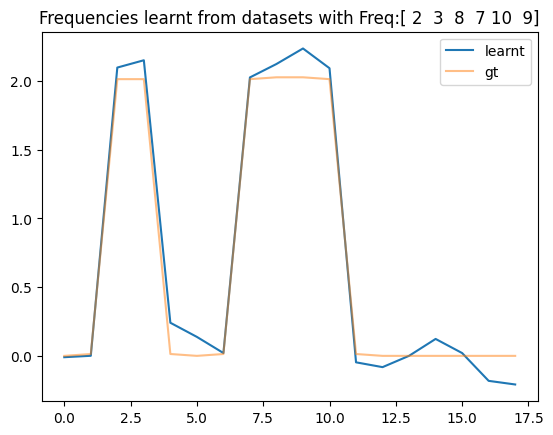

In [7]:
plt.figure()
plt.plot(targfreq, prods, label='learnt')
deltas = ca.deltafxn(targfreq, mydata.fixed_freqs)*2
plt.plot(targfreq, deltas, label='gt',alpha=0.5)

plt.title(f"""Frequencies learnt from datasets with Freq:{mydata.fixed_freqs}""")
plt.legend()

In [8]:
print(mymodel.dynamics_mask.shape)

torch.Size([12, 12])


In [9]:
import matplotlib.pyplot as plt

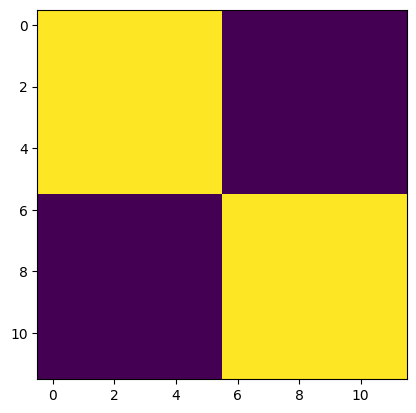

In [10]:
plt.imshow(mymodel.dynamics_mask)

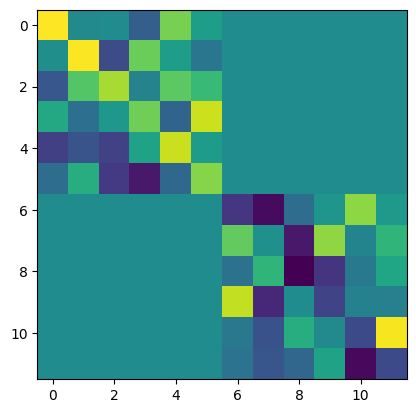

In [11]:
plt.imshow(Ms[0].detach().to("cpu"))

In [12]:
matsize = 12
blocksize = matsize // 2
block_ones = torch.ones(blocksize, blocksize, requires_grad=False)
block_zeros = torch.zeros(blocksize, blocksize, requires_grad=False)
mask1 = torch.block_diag(block_ones, block_zeros).to(Ms.device)
mask2 = torch.block_diag(block_zeros, block_ones).to(Ms.device)

In [13]:
block1_Ms = Ms * mask1

In [14]:
block2_Ms = Ms * mask2

Here!


100%|██████████| 18/18 [00:04<00:00,  3.81it/s]


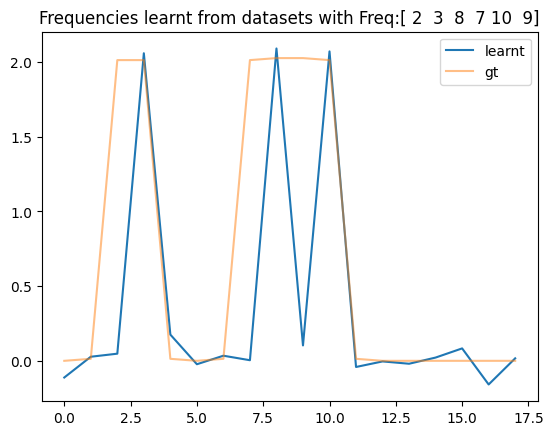

In [15]:
from importlib import reload
reload(ca)


print("Here!")
targfreq, prods = ca.inner_prod(block1_Ms, shifts, maxfreq, bins)

plt.figure()
plt.plot(targfreq, prods, label='learnt')
deltas = ca.deltafxn(targfreq, mydata.fixed_freqs)*2
plt.plot(targfreq, deltas, label='gt',alpha=0.5)

plt.title(f"""Frequencies learnt from datasets with Freq:{mydata.fixed_freqs}""")
plt.legend()

In [16]:
print([freq for freq in targfreq if prods[int(freq)].item() > 1.0])



[3.0, 8.0, 10.0]


100%|██████████| 18/18 [00:04<00:00,  4.00it/s]


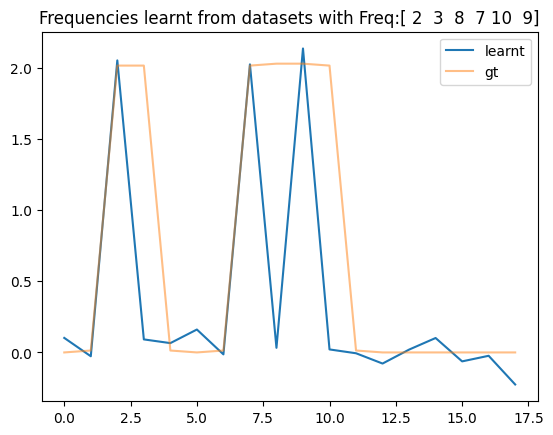

In [17]:
from importlib import reload
reload(ca)


targfreq, prods = ca.inner_prod(block2_Ms, shifts, maxfreq, bins)

plt.figure()
plt.plot(targfreq, prods, label='learnt')
deltas = ca.deltafxn(targfreq, mydata.fixed_freqs)*2
plt.plot(targfreq, deltas, label='gt',alpha=0.5)

plt.title(f"""Frequencies learnt from datasets with Freq:{mydata.fixed_freqs}""")
plt.legend()

In [18]:
print([freq for freq in targfreq if prods[int(freq)].item() > 1.0])



[2.0, 7.0, 9.0]
